In [135]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb

In [136]:
data=pd.read_csv("data_preped.csv")

In [137]:
data["date"]=pd.to_datetime(data["date"])

## GOLD

In [138]:
import yfinance as yf

gold = yf.download("GC=F", start="2010-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [139]:
#Resetujemy indeks, by mieć kolumnę 'Date'
gold = gold.reset_index()

#Obliczamy logarytmiczną stopę zwrotu
gold["Gold_LogReturn"] = np.log(gold["Close"] / gold["Close"].shift(1))

#Średnie kroczące z log return
gold["Gold_MA10"] = gold["Gold_LogReturn"].shift(1).rolling(window=10).mean()
gold["Gold_MA50"] = gold["Gold_LogReturn"].shift(1).rolling(window=50).mean()

#Zostawiamy tylko datę i nasze zmienne
gold = gold[["Date", "Gold_LogReturn", "Gold_MA10", "Gold_MA50"]]

In [140]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3771 entries, 0 to 3770
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   (Date, )            3771 non-null   datetime64[ns]
 1   (Gold_LogReturn, )  3770 non-null   float64       
 2   (Gold_MA10, )       3760 non-null   float64       
 3   (Gold_MA50, )       3720 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 118.0 KB


In [141]:
gold = gold.reset_index()  # zamienia indeks na zwykłą kolumnę 'Date'
gold.rename(columns={"Date": "date"}, inplace=True)

In [142]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3771 entries, 0 to 3770
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   (index, )           3771 non-null   int64         
 1   (date, )            3771 non-null   datetime64[ns]
 2   (Gold_LogReturn, )  3770 non-null   float64       
 3   (Gold_MA10, )       3760 non-null   float64       
 4   (Gold_MA50, )       3720 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 147.4 KB


In [143]:
gold.columns = [col[0] if isinstance(col, tuple) else col for col in gold.columns]

In [144]:
data = pd.merge(data, gold, on="date", how="left")

### Calendar trygo

In [145]:
data["month"]=data.date.dt.month
data["dayofyear"]=data.date.dt.dayofyear
data["dayofweek"]=data.date.dt.weekday
data["dayofmonth"]=data.date.dt.day

In [146]:
data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

data["dayofweek_sin"] = np.sin(2 * np.pi * data["dayofweek"] / 7)
data["dayofweek_cos"] = np.cos(2 * np.pi * data["dayofweek"] / 7)

data["dayofmonth_sin"] = np.sin(2 * np.pi * data["dayofmonth"] / 31)
data["dayofmonth_cos"] = np.cos(2 * np.pi * data["dayofmonth"] / 31)

data["dayofyear_sin"] = np.sin(2 * np.pi * data["dayofyear"] / 365)
data["dayofyear_cos"] = np.cos(2 * np.pi * data["dayofyear"] / 365)

data.drop(["month", "dayofweek", "dayofmonth", "dayofyear"], axis=1, inplace=True)

### Lags, rolling feats

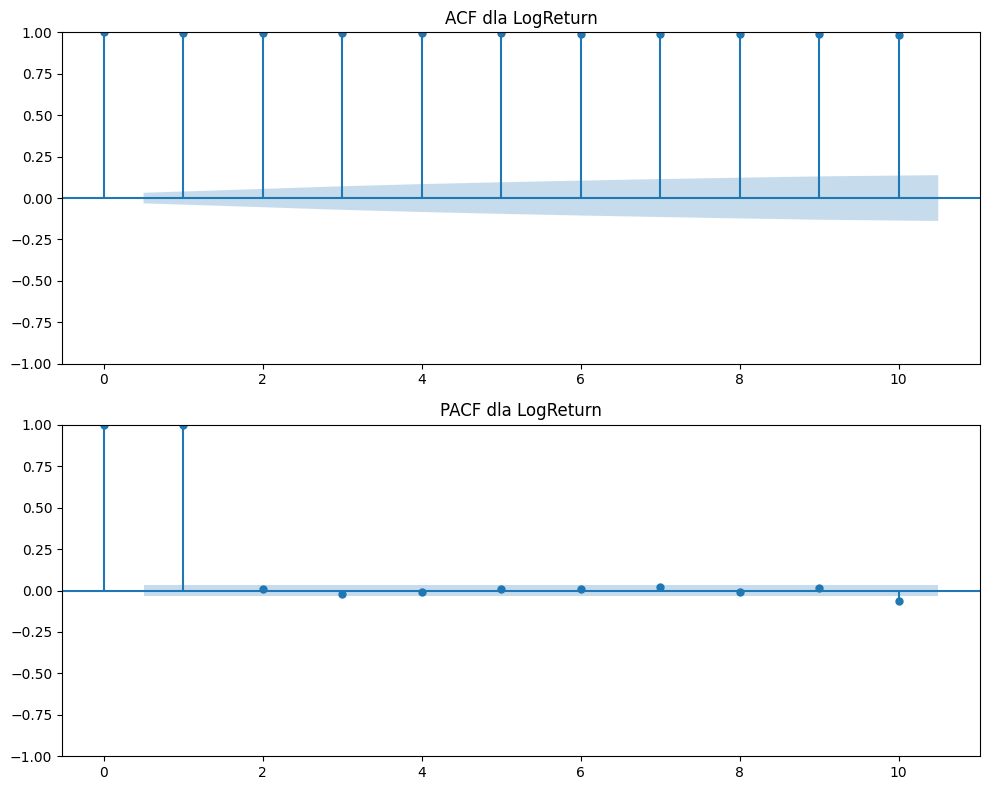

In [147]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Zakładamy, że masz już dane w data["LogReturn"]
log_returns = data["LogReturn"].dropna()

# Tworzymy 2 wykresy jeden pod drugim
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Wykres ACF
plot_acf(log_returns, lags=10, ax=axes[0])
axes[0].set_title("ACF dla LogReturn")

# Wykres PACF
plot_pacf(log_returns, lags=10, ax=axes[1])
axes[1].set_title("PACF dla LogReturn")

plt.tight_layout()
plt.show()


In [148]:
data['MA10'] = data['LogReturn'].shift(1).rolling(window=10).mean()
data['MA50'] = data['LogReturn'].shift(1).rolling(window=50).mean()
data['volatility_10'] = data['LogReturn'].shift(1).rolling(window=10).std()
ema12 = data['LogReturn'].shift(1).ewm(span=12).mean()
ema26 = data['LogReturn'].shift(1).ewm(span=26).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].shift(1).ewm(span=9).mean()
ma20 = data['LogReturn'].shift(1).rolling(window=20).mean()
std20 = data['LogReturn'].shift(1).rolling(window=20).std()
data['BB_upper'] = ma20 + 2*std20
data['BB_lower'] = ma20 - 2*std20



window = 14

delta = data['LogReturn'].diff().shift(1)

gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

rs = gain / loss

data['RSI'] = 100 - (100 / (1 + rs))

In [149]:
for i in range(1,11):
    data[f"LogReturn_lag{i}"] = data["LogReturn"].shift(i)

In [150]:
data.dropna(inplace=True)

In [151]:
data

,LogReturn,log_volume,ma_log_volume,prev_day_volume,date,gdp,interest_rate,unemployment,cpi,pce,...,LogReturn_lag1,LogReturn_lag2,LogReturn_lag3,LogReturn_lag4,LogReturn_lag5,LogReturn_lag6,LogReturn_lag7,LogReturn_lag8,LogReturn_lag9,LogReturn_lag10
61,1178.099976,22.111276,22.240729,4.484340e+09,2010-04-01,16690.0,0.16,9.9,217.353,90.261,...,1169.430054,1173.270020,1173.219971,1166.589966,1165.729980,1167.719971,1174.170044,1165.810059,1159.900024,1165.829956
62,1187.439941,22.079518,22.241507,4.006870e+09,2010-04-05,16690.0,0.16,9.9,217.353,90.261,...,1178.099976,1169.430054,1173.270020,1173.219971,1166.589966,1165.729980,1167.719971,1174.170044,1165.810059,1159.900024
63,1189.439941,22.130876,22.238369,3.881620e+09,2010-04-06,16690.0,0.16,9.9,217.353,90.261,...,1187.439941,1178.099976,1169.430054,1173.270020,1173.219971,1166.589966,1165.729980,1167.719971,1174.170044,1165.810059
64,1182.449951,22.352787,22.242334,4.086180e+09,2010-04-07,16690.0,0.16,9.9,217.353,90.261,...,1189.439941,1187.439941,1178.099976,1169.430054,1173.270020,1173.219971,1166.589966,1165.729980,1167.719971,1174.170044
65,1186.439941,22.276550,22.241516,5.101430e+09,2010-04-08,16690.0,0.16,9.9,217.353,90.261,...,1182.449951,1189.439941,1187.439941,1178.099976,1169.430054,1173.270020,1173.219971,1166.589966,1165.729980,1167.719971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,6040.040039,21.287283,22.165146,3.593280e+09,2024-12-24,23537.0,4.64,4.2,316.449,124.399,...,5974.069824,5930.850098,5867.080078,5872.160156,6050.609863,6074.080078,6051.089844,6051.250000,6084.189941,6034.910156
3770,6037.589844,21.789537,22.106913,1.757720e+09,2024-12-26,23537.0,4.64,4.2,316.449,124.399,...,6040.040039,5974.069824,5930.850098,5867.080078,5872.160156,6050.609863,6074.080078,6051.089844,6051.250000,6084.189941
3771,5970.839844,21.873714,22.093016,2.904530e+09,2024-12-27,23537.0,4.64,4.2,316.449,124.399,...,6037.589844,6040.040039,5974.069824,5930.850098,5867.080078,5872.160156,6050.609863,6074.080078,6051.089844,6051.250000
3772,5906.939941,21.956773,22.089892,3.159610e+09,2024-12-30,23537.0,4.64,4.2,316.449,124.399,...,5970.839844,6037.589844,6040.040039,5974.069824,5930.850098,5867.080078,5872.160156,6050.609863,6074.080078,6051.089844


### Normalization

In [152]:
data.columns

Index(['LogReturn', 'log_volume', 'ma_log_volume', 'prev_day_volume', 'date',
       'gdp', 'interest_rate', 'unemployment', 'cpi', 'pce',
       'nonfarm_payrolls', 'corporate_profits', 'money_supply',
       'consumer_confidence', 'housing_starts', 'permits',
       'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1',
       'interest_rate_roll3_mean', 'interest_rate_roll3_std', 'cpi_roll3_mean',
       'cpi_roll3_std', 'interest_x_cpi', 'unemp_x_gdp', 'index',
       'Gold_LogReturn', 'Gold_MA10', 'Gold_MA50', 'month_sin', 'month_cos',
       'dayofweek_sin', 'dayofweek_cos', 'dayofmonth_sin', 'dayofmonth_cos',
       'dayofyear_sin', 'dayofyear_cos', 'MA10', 'MA50', 'volatility_10',
       'MACD', 'MACD_signal', 'BB_upper', 'BB_lower', 'RSI', 'LogReturn_lag1',
       'LogReturn_lag2', 'LogReturn_lag3', 'LogReturn_lag4', 'LogReturn_lag5',
       'LogReturn_lag6', 'LogReturn_lag7', 'LogReturn_lag8', 'LogReturn_lag9',
       'LogReturn_lag10'],
      dtype='object')

In [153]:
columns_to_normalize = ['LogReturn','MA10','log_volume', 'ma_log_volume', 'prev_day_volume','BB_upper','BB_lower','MACD','MACD_signal','volatility_10','Gold_MA10','Gold_MA50','Gold_LogReturn','MA50','RSI','gdp', 'interest_rate', 'unemployment', 'cpi', 'pce', 'nonfarm_payrolls', 'corporate_profits', 
                        'money_supply', 'consumer_confidence', 'housing_starts', 'permits', 
                        'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1', 
                        'LogReturn', 'LogReturn_lag1', 'LogReturn_lag2', 'LogReturn_lag3', 
                        'LogReturn_lag4', 'LogReturn_lag5', 'LogReturn_lag6', 'LogReturn_lag7', 
                        'LogReturn_lag8', 'LogReturn_lag9', 'LogReturn_lag10']


scaler = StandardScaler()

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

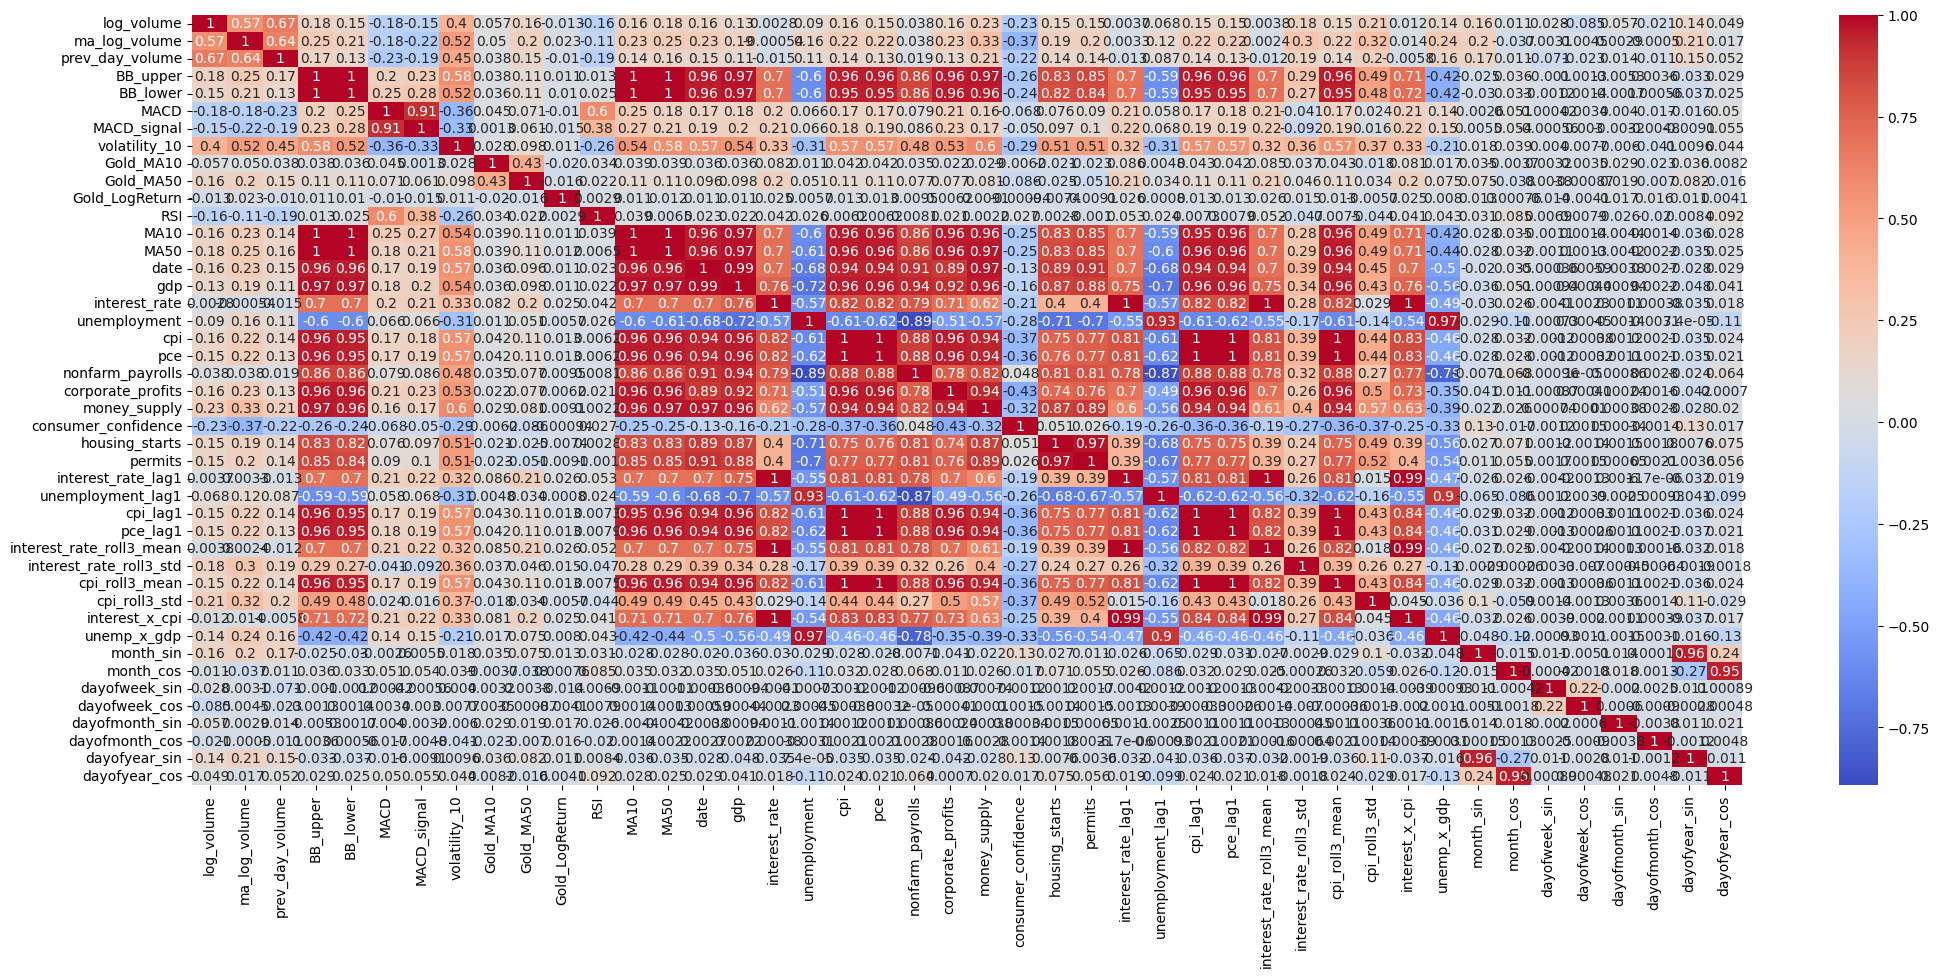

In [154]:
cor_data = data[['log_volume', 'ma_log_volume', 'prev_day_volume','BB_upper','BB_lower','MACD','MACD_signal','volatility_10','Gold_MA10','Gold_MA50','Gold_LogReturn','RSI','MA10','MA50', 'date', 'gdp', 'interest_rate', 'unemployment', 'cpi',
       'pce', 'nonfarm_payrolls', 'corporate_profits', 'money_supply',
       'consumer_confidence', 'housing_starts', 'permits',
       'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1',
       'interest_rate_roll3_mean', 'interest_rate_roll3_std', 'cpi_roll3_mean',
       'cpi_roll3_std', 'interest_x_cpi', 'unemp_x_gdp', 'month_sin',
       'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofmonth_sin',
       'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos']]
correlation = cor_data.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3710 entries, 61 to 3773
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LogReturn                 3710 non-null   float64       
 1   log_volume                3710 non-null   float64       
 2   ma_log_volume             3710 non-null   float64       
 3   prev_day_volume           3710 non-null   float64       
 4   date                      3710 non-null   datetime64[ns]
 5   gdp                       3710 non-null   float64       
 6   interest_rate             3710 non-null   float64       
 7   unemployment              3710 non-null   float64       
 8   cpi                       3710 non-null   float64       
 9   pce                       3710 non-null   float64       
 10  nonfarm_payrolls          3710 non-null   float64       
 11  corporate_profits         3710 non-null   float64       
 12  money_supply            

In [156]:
data['LogReturn']

61     -1.252821
62     -1.245400
63     -1.243811
64     -1.249365
65     -1.246195
          ...   
3769    2.610083
3770    2.608136
3771    2.555102
3772    2.504333
3773    2.484223
Name: LogReturn, Length: 3710, dtype: float64

In [157]:
data.to_csv("transformed_data.csv",index=False)